In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import SplineTransformer

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import svm

from bgspy.learn import LearnedFunction, LearnedB
from bgspy.theory import bgs_segment


In [3]:
f = LearnedFunction.load("../data/slim_sims/bmap_hg38_reps/bmap_hg38_reps_data.pkl")
f.split()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, None)
  - sh ∈ [-5, -1] (log10, None)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, None)
  - rf ∈ [-10, -0.824] (log10, None)
 fixed fixed(s) (based on metadata):
Features normalized? False
Features split? True, test size: 20.0% (n=40,000)
Total size: 200,000

In [4]:
# if log transform y
regressor = LinearRegression()
regr = TransformedTargetRegressor(regressor=Ridge(),
                                  func=np.log,
                                  inverse_func=np.exp)

In [5]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('poly', PolynomialFeatures()), 
                       #('spline', SplineTransformer()),                        
                       ('regr', Ridge())])

X = f.X_train 
y = f.y_train

N = 1000
fun = bgs_segment(*X.T)
y = np.random.exponential(fun * 2*N) / (2*N)

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipe.fit(X, y)

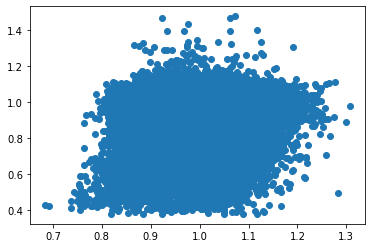

In [7]:
plt.scatter(f.y_test, pipe.predict(f.X_test))

0.06702330524492332

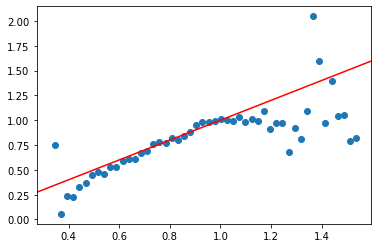

In [8]:
def binned_plot(model, X_test, y_test, nbins):
    ypred = model.predict(X_test)
    bins = np.linspace(ypred.min(), ypred.max(), nbins)
    y_bins = stats.binned_statistic(ypred, y_test, bins=nbins)
    edges = y_bins.bin_edges
    x = 0.5*(edges[:-1]+edges[1:])
    y =  y_bins.statistic
    plt.scatter(x, y)
    o = min(edges)
    plt.axline((o, o), slope=1, c='r')
    xx, yy = x[y <= 1], y[y <= 1]
    return np.nanmean((xx-yy)**2)
    
binned_plot(pipe, X, y, 50)

In [9]:
param_grid = {#'spline__n_knots': [3, 5, 10], 
              #'spline__degree': np.arange(1, 10), 
              'poly__degree': np.arange(1, 10),
              #'regr__regressor__alpha': np.logspace(-3, 2, 10)}
              'regr__alpha': np.logspace(-3, 2, 10)}
              

In [10]:
def bhat_scorer(y_true, y_pred):
    w = (y_true - y_pred)**2
    w[(y_true > 1) | (y_pred > 1)] = np.nan
    return np.nanmean(w)

bhat_scorer = make_scorer(bhat_scorer, greater_is_better=False)

In [15]:
search = GridSearchCV(pipe, param_grid, 
                      scoring=bhat_scorer,
                      #scoring='neg_mean_squared_error', 
                      cv=5, n_jobs=50)

In [16]:
search.fit(f.X_train, f.y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('poly', PolynomialFeatures()),
                                       ('regr', Ridge())]),
             n_jobs=50,
             param_grid={'poly__degree': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'regr__alpha': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02])},
             scoring=make_scorer(bhat_scorer, greater_is_better=False))

In [17]:
print(search.best_params_)

{'poly__degree': 7, 'regr__alpha': 0.1668100537200059}


/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.86112e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.28897e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.59877e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.56244e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/vsb/mi

0.0025289043619366254


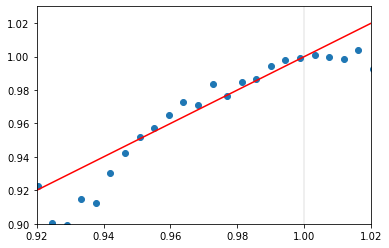

In [14]:
print(binned_plot(search, f.X_test, f.y_test, 100))
plt.xlim(0.92, 1.02)
plt.ylim(0.9, 1.03)
plt.axvline(1, c='0.22', alpha=0.1, zorder=-1)

In [77]:
nreps = 50
2/(9*nreps)

0.0044444444444444444

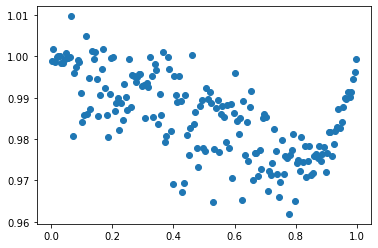

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 298, in _score
    y_pred = method_caller(clf, "predict_proba", X)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 68, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/skl

In [78]:
X = f.X_train_raw
btheory = bgs_segment(*X.T)
rate = X[:, 0] / X[:, 1]
x = btheory
y = f.y_train #pipe.predict(X)

nbins = 190
bins = np.linspace(y.min(), y.max(), nbins)
y_bins = stats.binned_statistic(x, y, bins=nbins)
edges = y_bins.bin_edges
x = 0.5*(edges[:-1]+edges[1:])
yb =  y_bins.statistic

#idx = np.arange(X.shape[0])#rate > 1e-4
idx = rate > 1e-4

plt.scatter(x, yb)


In [18]:
btheory, y

(array([0.99998484, 0.99954359, 0.9997344 , ..., 0.10756291, 0.99996123,
        0.99825133]),
 array([0.93891431, 1.05307879, 1.01439698, ..., 1.03619677, 0.93764883,
        0.83524091]))

[]

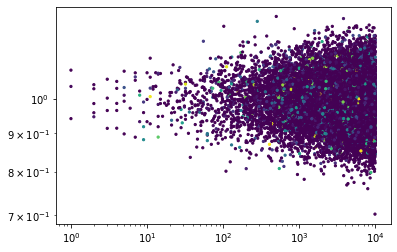

In [19]:
plt.scatter(X[idx, 2], y[idx], s=5, c=X[idx, 4])
plt.loglog()

0.049333895775963095


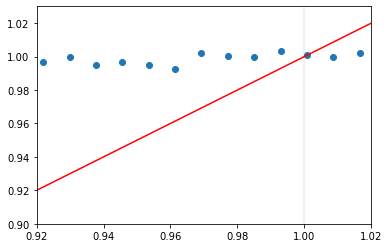

In [20]:
print(binned_plot(pipe, f.X_test, f.y_test, 100))
plt.xlim(0.92, 1.02)
plt.ylim(0.9, 1.03)
plt.axvline(1, c='0.22', alpha=0.1, zorder=-1)